# Setup

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_syster(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.12.0


# Load in Data

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [7]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [11]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [12]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [13]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [14]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

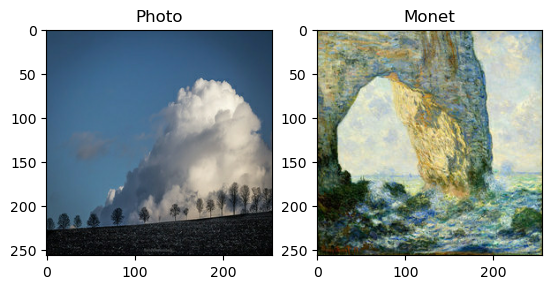

In [15]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Build the Generator

The generator creates fake Monets from the photo images.

## Downsample
This function reduces the size of the image by half using convolution.

In [22]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    
    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    
    return result

## Upsample

This function doubles the size of the image using Conv2DTranspose, which reverses the process of convolution.

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    
    result.add(layers.ReLU())
    
    return result

## Generator

The generator first downsamples the image then upsamples it with skip connections. Skip connections help avoid vanishing gradients.

In [18]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(filters=64, size=4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    
    initializer = tf.random_normal_initializer(0, 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')
    
    x = inputs
    
    # downsample
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # upsampling with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

# Build the Discriminator

The discriminator takes in an image and classifies it as a real or fake Monet.

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = layers.ZeroPadding2D()(down3)
    
    conv = layers.Conv2D(512, 4, strides=1,
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)
    
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    
    leaky_relu = layers.LeakyReLU()(norm1)
    
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    
    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=inp, outputs=last)

In [23]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()
    
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

<function matplotlib.pyplot.show(close=None, block=None)>

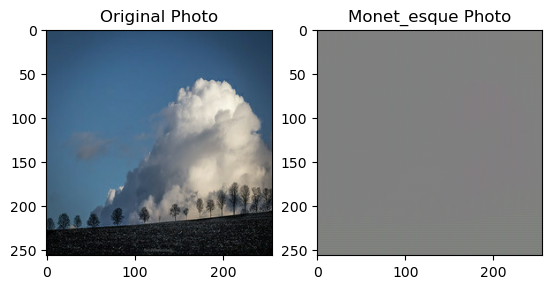

In [24]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet_esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show

# Build the Model

In [67]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_monet = self.p_gen(fake_monet, training=True)
            
            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_photo = self.m_gen(fake_photo, training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            #discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # evaluate generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # evaluate total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
                
            # evaluate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
                
            # evaluate discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
            # calculate gradient for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                     self.m_gen.trainable_variables)
            photo_generator_gradients = tape.gradient(total_photo_gen_loss, 
                                                      self.p_gen.trainable_variables)
            monet_discriminator_gradients = tape.gradient(monet_disc_loss, 
                                                         self.m_disc.trainable_variables)
            photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                         self.p_disc.trainable_variables)
            
            # apply the gradients to the optimizer
            self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                    self.m_gen.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                    self.p_gen.trainable_variables))
            self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                    self.m_disc.trainable_variables))
            self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                     self.p_disc.trainable_variables))
            
            return {
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss
            }

# Define the Loss Function

The loss function compares the results to an ideal result of all 1's. The discriminator loss ouputs the average of the real and generated loss.

In [63]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        
        total_disc_loss = real_loss + generated_loss
        
        return total_disc_loss * 0.5

In [31]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [57]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA * loss1

The identity loss compares the image with its generator. Given a photo, we want it to generate the same image. Identity loss compares the input image to the output image.

In [32]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the Model

In [46]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [68]:
with strategy.scope():
    cycle_gan_model = CycleGan(monet_generator,
                              photo_generator,
                              monet_discriminator,
                              photo_discriminator)
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
    156/Unknown - 951s 6s/step - monet_gen_loss: 10.8198 - photo_gen_loss: 11.3356 - monet_disc_loss: 0.6347 - photo_disc_loss: 0.5878

# Visualize Results

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show

# Create Submission File

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.absuint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")